In [1]:
# --- Cell 1: Imports ---
print("--- Importing Essential Libraries ---")

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay

# Optional: Import LightGBM and XGBoost
try:
    import lightgbm as lgb
    print("LightGBM imported successfully.")
except ImportError:
    print("LightGBM not installed. It will be skipped in model training.")
    lgb = None

try:
    from xgboost import XGBClassifier
    print("XGBoost imported successfully.")
except ImportError:
    print("XGBoost not installed. It will be skipped in model training.")
    XGBClassifier = None

# Set some display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

print("\n--- Imports Complete ---")

--- Importing Essential Libraries ---
LightGBM imported successfully.
XGBoost imported successfully.

--- Imports Complete ---


In [2]:
# --- Cell 2: Data Loading, Naming, and Saving Checkpoint ---
print("--- Starting Data Loading ---")

output_csv_filename = 'merged_nids_dataset.csv'
output_csv_path = os.path.join('.', output_csv_filename)
merged_df = None

if os.path.exists(output_csv_path):
    print(f"Loading data from existing checkpoint: {output_csv_path}")
    try:
        merged_df = pd.read_csv(output_csv_path, low_memory=False)
        print("Data loaded successfully from checkpoint.")
    except Exception as e:
        print(f"Error loading checkpoint file: {e}. Will proceed to merge raw data.")
else:
    print("Checkpoint file not found. Proceeding to merge raw data...")

if merged_df is None:
    features_file_path = os.path.join('.', 'NUSW-NB15_features.csv')
    column_names = None
    try:
        features_df = pd.read_csv(features_file_path, encoding='ISO-8859-1')
        column_names = features_df.iloc[:, 1].tolist()
        if 'Label' in column_names:
            column_names[column_names.index('Label')] = 'label'
        print(f"Successfully read {len(column_names)} column names.")
    except Exception as e:
        print(f"Error reading features file: {e}")

    if column_names:
        data_files = ['UNSW-NB15_1.csv', 'UNSW-NB15_2.csv', 'UNSW-NB15_3.csv', 'UNSW-NB15_4.csv']
        dataframes = []
        for file_name in data_files:
            try:
                df = pd.read_csv(os.path.join('.', file_name), header=None, low_memory=False)
                dataframes.append(df)
            except Exception as e:
                print(f"Error reading {file_name}: {e}. Skipping.")
        
        if len(dataframes) == len(data_files):
            merged_df = pd.concat(dataframes, ignore_index=True)
            merged_df.columns = column_names
            print("Raw data merged and columns named.")
            try:
                merged_df.to_csv(output_csv_path, index=False)
                print(f"Merged DataFrame saved to checkpoint: {output_csv_path}")
            except Exception as e:
                print(f"Error saving checkpoint file: {e}")
        else:
            print("ERROR: Not all raw data files were read successfully.")

if 'merged_df' in locals() and merged_df is not None:
    print(f"\nFinal DataFrame shape after loading/merging: {merged_df.shape}")
else:
    print("\nERROR: DataFrame not available.")

print("\n--- Data Loading Complete ---")

--- Starting Data Loading ---
Loading data from existing checkpoint: .\merged_nids_dataset.csv
Data loaded successfully from checkpoint.

Final DataFrame shape after loading/merging: (2540047, 49)

--- Data Loading Complete ---


In [3]:
# --- Cell 3: Data Cleaning (Pre-Split) ---
print("--- Starting Data Cleaning ---")

if 'merged_df' in locals() and merged_df is not None:
    # 1. Drop initial columns (attack_cat, high missing, IPs)
    cols_to_drop = ['attack_cat', 'ct_flw_http_mthd', 'is_ftp_login', 'srcip', 'dstip']
    merged_df = merged_df.drop(columns=cols_to_drop, errors='ignore').copy()

    # 2. Handle Duplicates
    num_duplicates = merged_df.duplicated().sum()
    if num_duplicates > 0:
        merged_df = merged_df.drop_duplicates().copy()

    # 3. Type Conversions & Renaming
    for col_name in ['sport', 'dsport', 'ct_ftp_cmd']:
        if col_name in merged_df.columns:
            merged_df.loc[:, col_name] = pd.to_numeric(merged_df[col_name], errors='coerce').fillna(0).astype(int)
    if 'ct_src_ ltm' in merged_df.columns:
        merged_df.rename(columns={'ct_src_ ltm': 'ct_src_ltm'}, inplace=True)
    
    # 4. Limit Cardinality of 'service' - CRUCIAL STEP
    service_col = 'service'
    if service_col in merged_df.columns:
        service_counts = merged_df[service_col].value_counts()
        # Keep the top N most frequent categories and group the rest into 'Other_Service'
        # Let's keep the top 10 as an example, as this is a common practice
        top_n = 10 
        top_services = service_counts.nlargest(top_n).index
        # Replace categories not in the top N with 'Other_Service'
        merged_df.loc[:, service_col] = np.where(merged_df[service_col].isin(top_services), merged_df[service_col], 'Other_Service')
        print(f"\nLimited 'service' column to top {top_n} categories + 'Other_Service'.")
        print(f"New unique service categories: {merged_df[service_col].nunique()}")

    # 5. Drop Highly Correlated Features
    numerical_cols_for_corr = merged_df.select_dtypes(include=np.number).columns.tolist()
    if 'Label' in numerical_cols_for_corr: numerical_cols_for_corr.remove('Label')
    corr_matrix_numeric = merged_df[numerical_cols_for_corr].corr().abs()
    upper = corr_matrix_numeric.where(np.triu(np.ones(corr_matrix_numeric.shape), k=1).astype(bool))
    threshold = 0.95
    cols_to_drop_corr = [column for column in upper.columns if any(upper[column] > threshold)]
    if cols_to_drop_corr:
        merged_df = merged_df.drop(columns=cols_to_drop_corr, errors='ignore').copy()
        print(f"\nDropped {len(cols_to_drop_corr)} highly correlated features.")
        
    # 6. Log Transformation
    cols_for_log = [col for col in ['dur', 'sbytes', 'dbytes', 'Sload', 'Dload', 'Spkts'] if col in merged_df.columns]
    for col in cols_for_log:
        merged_df.loc[:, col] = np.log1p(merged_df[col])
    print("\nApplied log transformation to key numerical features.")

    print(f"\nShape after all cleaning: {merged_df.shape}")
else:
    print("\nDataFrame not available.")

print("\n--- Data Cleaning Complete ---")

--- Starting Data Cleaning ---

Limited 'service' column to top 10 categories + 'Other_Service'.
New unique service categories: 11

Dropped 5 highly correlated features.

Applied log transformation to key numerical features.

Shape after all cleaning: (2048193, 39)

--- Data Cleaning Complete ---


C:\Users\Soham\AppData\Local\Temp\ipykernel_30804\1436434189.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4.89034913 6.27098843 4.99043259 ... 5.77144112 8.16023249 6.35437004]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_df.loc[:, col] = np.log1p(merged_df[col])
C:\Users\Soham\AppData\Local\Temp\ipykernel_30804\1436434189.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5.10594547  5.72031178  5.18738581 ...  7.51152465 12.02007434
  6.51767127]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_df.loc[:, col] = np.log1p(merged_df[col])
C:\Users\Soham\AppData\Local\Temp\ipykernel_30804\1436434189.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.09861229 1

In [4]:
# --- Cell 4: Feature Selection (on a Sample) - Corrected & Compatible Version ---
print("--- Starting Feature Selection on a Sample ---")

if 'merged_df' in locals() and merged_df is not None:
    
    # --- 1. Create a Stratified Sample using train_test_split (Compatibility Fix) ---
    sample_frac = 0.20 # Using 20% of the data
    print(f"Taking a {sample_frac*100}% stratified sample of the data...")
    
    # We use train_test_split to get a stratified sample. We only need the 'train' part.
    if 'label' in merged_df.columns:
        # Create temporary X and y from the full dataset for the split
        X_temp_full = merged_df.drop('label', axis=1)
        y_temp_full = merged_df['label']
        
        # The first set of returned values (X_sample, y_sample) is our stratified sample
        # The '_' placeholders are for the "test" part, which we discard here.
        X_sample, _, y_sample, _ = train_test_split(
            X_temp_full, y_temp_full, 
            train_size=sample_frac, 
            random_state=42, 
            stratify=y_temp_full
        )
        print(f"Stratified sample created successfully. Shape: {X_sample.shape}")
    else:
        print("Warning: 'label' column not found for stratification. Taking a random sample.")
        # As a fallback, take a random sample
        df_sample = merged_df.sample(frac=sample_frac, random_state=42)
        X_sample = df_sample.drop('label', axis=1, errors='ignore')
        y_sample = df_sample['label']


    # --- 2. CRUCIAL MEMORY FIX: Limit Cardinality of ALL Categorical Features in the Sample ---
    print("\nIdentifying and limiting cardinality of all categorical features in the sample...")
    # Get all columns that are of 'object' type from our sample
    categorical_cols_sample = X_sample.select_dtypes(include='object').columns.tolist()
    
    # Define a safe threshold for the number of unique categories
    cardinality_threshold = 50 

    for col in categorical_cols_sample:
        num_unique = X_sample[col].nunique()
        if num_unique > cardinality_threshold:
            print(f"Limiting cardinality for '{col}' (had {num_unique} unique values).")
            # Find the top N-1 most frequent categories
            top_categories = X_sample[col].value_counts().nlargest(cardinality_threshold - 1).index
            # Replace all other less frequent categories with a single 'Other' category
            # Use .loc to ensure we are modifying the X_sample DataFrame directly
            X_sample.loc[:, col] = np.where(X_sample[col].isin(top_categories), X_sample[col], 'Other')
            print(f"'{col}' cardinality limited. New unique count: {X_sample[col].nunique()}")

    # --- 3. One-Hot Encode the Cardinality-Limited Sample ---
    print("\nPerforming One-Hot Encoding on the sample...")
    # Now, pd.get_dummies will be memory-safe because cardinality is limited
    X_sample_encoded = pd.get_dummies(X_sample, columns=categorical_cols_sample, dtype=int)
    print(f"Sample encoded successfully. New shape: {X_sample_encoded.shape}")


    # --- 4. Calculate Feature Importance on the Sample ---
    print("\nTraining RandomForest on sample to get feature importances...")
    if 'RandomForestClassifier' in globals() and RandomForestClassifier is not None:
        rf_for_importance = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf_for_importance.fit(X_sample_encoded, y_sample)

        # Get and select top features
        importances = rf_for_importance.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': X_sample_encoded.columns, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        n_features_to_keep = 66
        top_n_features = feature_importance_df['feature'].head(n_features_to_keep).tolist()
        print(f"\nSelected top {n_features_to_keep} feature names.")

        # --- 5. Subset the Entire DataFrame with Selected Original Features ---
        # We need to map the one-hot encoded feature names back to their original column names
        original_cols_to_keep = set()
        for feature in top_n_features:
            # For one-hot encoded features (e.g., 'service_http'), the original column is 'service'
            # This logic assumes the format 'original_column_name_category'
            original_col = feature.split('_')[0]
            if original_col in merged_df.columns:
                original_cols_to_keep.add(original_col)
        
        # Also add any numerical columns that made it into the top features
        numerical_cols_in_top = [col for col in top_n_features if col in X_sample.select_dtypes(include=np.number).columns]
        original_cols_to_keep.update(numerical_cols_in_top)
        
        # Finally, add the 'label' column to keep it for splitting later
        features_to_keep_final = list(original_cols_to_keep) + ['label']
        
        # Subset the main merged_df with these original feature names
        merged_df_selected = merged_df[[col for col in features_to_keep_final if col in merged_df.columns]].copy()
        
        print(f"\nFinal shape of DataFrame after feature selection: {merged_df_selected.shape}")

    else:
        print("RandomForestClassifier not available. Cannot select features.")
        # As a fallback, we'll use the full cleaned dataframe
        merged_df_selected = merged_df.copy()

else:
    print("\nDataFrame not available for feature selection. Please run Cell 3.")
    merged_df_selected = None

print("\n--- Feature Selection Complete ---")

--- Starting Feature Selection on a Sample ---
Taking a 20.0% stratified sample of the data...
Stratified sample created successfully. Shape: (409638, 38)

Identifying and limiting cardinality of all categorical features in the sample...
Limiting cardinality for 'sport' (had 64381 unique values).
'sport' cardinality limited. New unique count: 50
Limiting cardinality for 'dsport' (had 56310 unique values).
'dsport' cardinality limited. New unique count: 50
Limiting cardinality for 'proto' (had 112 unique values).
'proto' cardinality limited. New unique count: 50

Performing One-Hot Encoding on the sample...
Sample encoded successfully. New shape: (409638, 216)

Training RandomForest on sample to get feature importances...

Selected top 66 feature names.

Final shape of DataFrame after feature selection: (2048193, 38)

--- Feature Selection Complete ---


In [5]:
# --- Cell 5: Final Preprocessing (Split, OHE, Scale) ---
print("--- Starting Final Preprocessing on Selected Features ---")

if 'merged_df_selected' in locals() and merged_df_selected is not None:
    X = merged_df_selected.drop('label', axis=1)
    y = merged_df_selected['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print(f"Data split complete. X_train shape: {X_train.shape}")

    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    print(f"Identified {len(categorical_cols)} categorical and {len(numerical_cols)} numerical features.")

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
        ])

    print("\nFitting preprocessor and transforming train/test sets...")
    X_train_processed_sparse = preprocessor.fit_transform(X_train)
    X_test_processed_sparse = preprocessor.transform(X_test)
    print(f"Shape of final sparse training data: {X_train_processed_sparse.shape}")
else:
    print("\nFeature-selected DataFrame not found. Please run Cell 4.")
    X_train_processed_sparse, X_test_processed_sparse = None, None

print("\n--- Final Preprocessing Complete ---")

--- Starting Final Preprocessing on Selected Features ---
Data split complete. X_train shape: (1433735, 37)
Identified 5 categorical and 32 numerical features.

Fitting preprocessor and transforming train/test sets...
Shape of final sparse training data: (1433735, 129335)

--- Final Preprocessing Complete ---


In [6]:
# --- Cell 6: Apply SMOTE to Training Data ---
print("--- Applying SMOTE to Processed Training Data ---")

if 'X_train_processed_sparse' in locals() and 'y_train' in locals():
    smote = SMOTE(random_state=42, n_jobs=-1)
    print(f"\nOriginal training data shape: {X_train_processed_sparse.shape}")
    print(f"Original y_train class distribution:\n{y_train.value_counts(normalize=True)}")

    X_train_smote, y_train_smote = smote.fit_resample(X_train_processed_sparse, y_train)
    print("\nSMOTE oversampling complete.")
    print(f"Shape of resampled training data: {X_train_smote.shape}")
    print(f"Class distribution after SMOTE:\n{Counter(y_train_smote)}")
else:
    print("\nProcessed sparse training data not found. Please run Cell 5.")
    X_train_smote, y_train_smote = None, None

print("\n--- SMOTE Application Complete ---")

--- Applying SMOTE to Processed Training Data ---

Original training data shape: (1433735, 129335)
Original y_train class distribution:
label
0    0.956623
1    0.043377
Name: proportion, dtype: float64


D:\NIDS\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(



SMOTE oversampling complete.
Shape of resampled training data: (2743088, 129335)
Class distribution after SMOTE:
Counter({0: 1371544, 1: 1371544})

--- SMOTE Application Complete ---


In [7]:
# --- Cell 7: Train and Evaluate Models WITHOUT SMOTE - Corrected ---
print("--- Starting Model Training and Evaluation WITHOUT SMOTE ---")

results_without_smote = {}
feature_importances_without_smote = {}

if 'X_train_processed_sparse' in locals() and 'X_test_processed_sparse' in locals():
    # Define models
    models_to_train = {
        'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()) if XGBClassifier else None,
        'LightGBM': lgb.LGBMClassifier(random_state=42, n_jobs=-1, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()) if lgb else None
    }

    for name, model in models_to_train.items():
        # --- THIS IS THE CORRECTED LINE ---
        if model is not None:
            print(f"\nTraining {name} (No SMOTE)...")
            start_time = time.time()
            model.fit(X_train_processed_sparse, y_train)
            train_time = time.time() - start_time
            print(f"Training complete in {train_time:.2f} seconds.")

            y_pred = model.predict(X_test_processed_sparse)
            y_pred_proba = model.predict_proba(X_test_processed_sparse)[:, 1]

            results_without_smote[f"{name} (No SMOTE)"] = {
                'accuracy': accuracy_score(y_test, y_pred), 'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
                'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0), 'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
                'roc_auc': roc_auc_score(y_test, y_pred_proba), 'confusion_matrix': confusion_matrix(y_test, y_pred),
                'train_time_sec': train_time, 'y_pred_proba': y_pred_proba }
            
            if hasattr(model, 'feature_importances_'):
                # Get feature names from the preprocessor used to create the sparse matrix
                feature_names = preprocessor.get_feature_names_out()
                feature_importances_without_smote[f"{name} (No SMOTE)"] = (model.feature_importances_, feature_names)
else:
    print("\nData not available. Cannot train models.")

print("\n--- Model Training WITHOUT SMOTE Complete ---")

--- Starting Model Training and Evaluation WITHOUT SMOTE ---

Training Logistic Regression (No SMOTE)...
Training complete in 266.72 seconds.

Training RandomForest (No SMOTE)...
Training complete in 1139.34 seconds.

Training XGBoost (No SMOTE)...


D:\NIDS\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:48:07] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training complete in 28.93 seconds.

Training LightGBM (No SMOTE)...
[LightGBM] [Info] Number of positive: 62191, number of negative: 1371544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.734436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 144026
[LightGBM] [Info] Number of data points in the train set: 1433735, number of used features: 69410
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043377 -> initscore=-3.093482
[LightGBM] [Info] Start training from score -3.093482
Training complete in 16.36 seconds.

--- Model Training WITHOUT SMOTE Complete ---


In [8]:
# --- Cell 8: Train and Evaluate Models WITH SMOTE - Corrected ---
print("--- Starting Model Training and Evaluation WITH SMOTE ---")

results_with_smote = {}
feature_importances_with_smote = {}

if 'X_train_smote' in locals() and 'X_test_processed_sparse' in locals():
    # Define models
    models_to_train_smote = {
        'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42) if XGBClassifier else None,
        'LightGBM': lgb.LGBMClassifier(random_state=42, n_jobs=-1) if lgb else None
    }

    for name, model in models_to_train_smote.items():
        # --- THIS IS THE CORRECTED LINE ---
        if model is not None:
            print(f"\nTraining {name} (With SMOTE)...")
            start_time = time.time()
            model.fit(X_train_smote, y_train_smote)
            train_time = time.time() - start_time
            print(f"Training complete in {train_time:.2f} seconds.")

            y_pred = model.predict(X_test_processed_sparse)
            y_pred_proba = model.predict_proba(X_test_processed_sparse)[:, 1]

            results_with_smote[f"{name} (With SMOTE)"] = {
                'accuracy': accuracy_score(y_test, y_pred), 'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
                'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0), 'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
                'roc_auc': roc_auc_score(y_test, y_pred_proba), 'confusion_matrix': confusion_matrix(y_test, y_pred),
                'train_time_sec': train_time, 'y_pred_proba': y_pred_proba }
                
            if hasattr(model, 'feature_importances_'):
                # Get feature names from the preprocessor used to create the sparse matrix
                feature_names = preprocessor.get_feature_names_out()
                feature_importances_with_smote[f"{name} (With SMOTE)"] = (model.feature_importances_, feature_names)
else:
    print("\nSMOTE'd data not available. Cannot train models.")

print("\n--- Model Training WITH SMOTE Complete ---")

--- Starting Model Training and Evaluation WITH SMOTE ---

Training Logistic Regression (With SMOTE)...
Training complete in 857.27 seconds.

Training RandomForest (With SMOTE)...
Training complete in 5449.98 seconds.

Training XGBoost (With SMOTE)...


D:\NIDS\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:34:36] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training complete in 139.39 seconds.

Training LightGBM (With SMOTE)...
[LightGBM] [Info] Number of positive: 1371544, number of negative: 1371544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 387.522137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219122
[LightGBM] [Info] Number of data points in the train set: 2743088, number of used features: 85369
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training complete in 824.97 seconds.

--- Model Training WITH SMOTE Complete ---


In [9]:
# --- Cell 9: Compile and Compare All Results ---
print("--- Compiling and Comparing Model Results ---")

if 'results_without_smote' in locals() and 'results_with_smote' in locals():
    all_results = {**results_without_smote, **results_with_smote}
    if all_results:
        results_df = pd.DataFrame(all_results).T
        metrics_order = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc', 'train_time_sec']
        cm_cols = ['TN', 'FP', 'FN', 'TP']
        if 'confusion_matrix' in results_df.columns:
            for cm_col in cm_cols:
                 results_df[cm_col] = results_df['confusion_matrix'].apply(lambda cm: cm.ravel().tolist()[cm_cols.index(cm_col)])
        final_columns = metrics_order + cm_cols
        
        print("\n--- Model Performance Comparison ---")
        print(results_df[final_columns].round(4))
    else:
        print("\nNo results found to compare.")
else:
    print("\nResults dictionaries not found.")

print("\n--- Model Comparison Complete ---")

--- Compiling and Comparing Model Results ---

--- Model Performance Comparison ---
                                  accuracy precision_macro recall_macro  \
Logistic Regression (No SMOTE)    0.990505        0.949871     0.933988   
RandomForest (No SMOTE)           0.993731        0.968318     0.955284   
XGBoost (No SMOTE)                0.987334        0.887424     0.992305   
LightGBM (No SMOTE)               0.986115        0.878927     0.992277   
Logistic Regression (With SMOTE)  0.986217        0.880225     0.990647   
RandomForest (With SMOTE)         0.991597        0.927252     0.981067   
XGBoost (With SMOTE)              0.991239        0.926283     0.977352   
LightGBM (With SMOTE)             0.990359        0.918342     0.977554   

                                  f1_macro   roc_auc train_time_sec      TN  \
Logistic Regression (No SMOTE)    0.941772  0.998545     266.722124  585379   
RandomForest (No SMOTE)           0.961699  0.999237    1139.343981  586266   
XGB

--- Generating Performance Visualizations ---


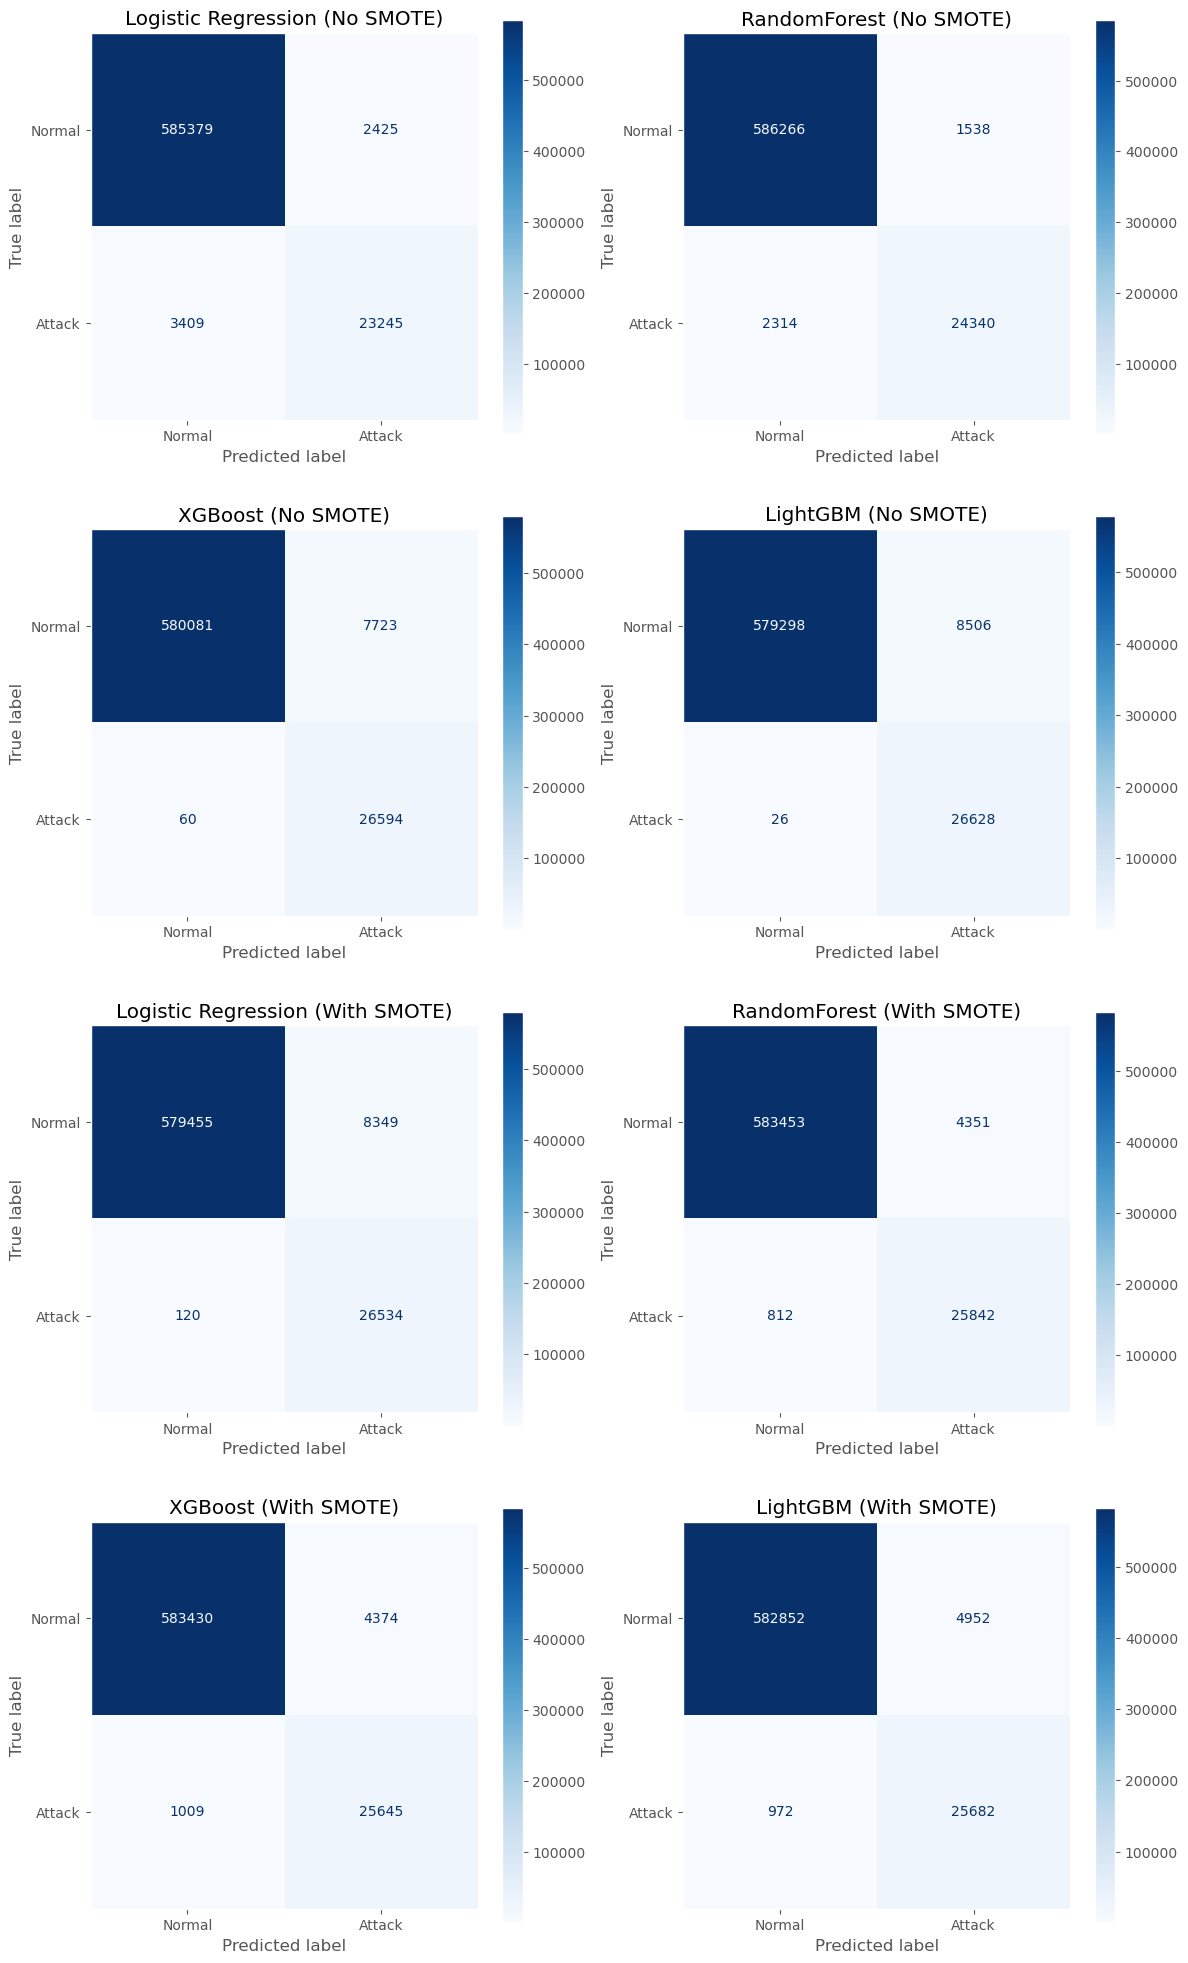

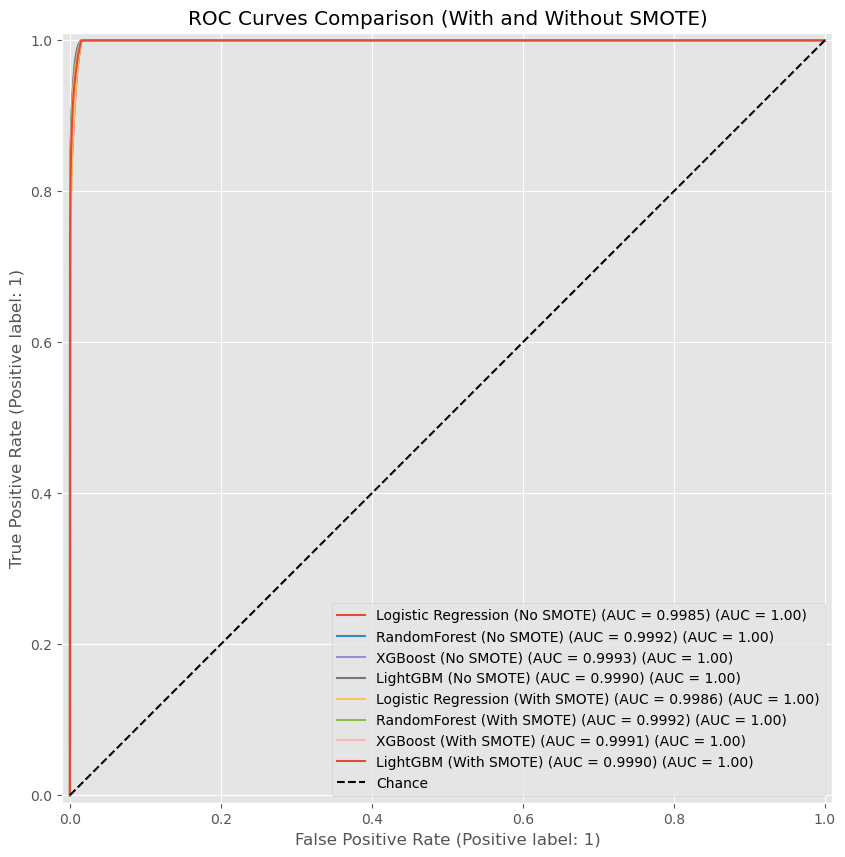


--- Visualization Complete ---


In [10]:
# --- Cell 10: Performance Visualizations ---
print("--- Generating Performance Visualizations ---")

if 'all_results' in locals() and all_results:
    # --- Confusion Matrix Plots ---
    n_models = len(all_results)
    n_cols = 2
    n_rows = (n_models + n_cols - 1) // n_cols
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 5))
    axes = axes.flatten() if n_models > 1 else [axes]
    
    for i, (name, result) in enumerate(all_results.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'], display_labels=['Normal', 'Attack'])
        disp.plot(ax=axes[i], cmap=plt.cm.Blues, values_format='d')
        axes[i].set_title(name)
        axes[i].grid(False)
    
    for j in range(n_models, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

    # --- ROC Curve Plot ---
    plt.figure(figsize=(12, 10))
    ax = plt.gca()
    for name, result in all_results.items():
        if 'y_pred_proba' in result:
            RocCurveDisplay.from_predictions(y_test, result['y_pred_proba'], name=f"{name} (AUC = {result['roc_auc']:.4f})", ax=ax)
    
    plt.title('ROC Curves Comparison (With and Without SMOTE)')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

else:
    print("\nNo model results found to visualize.")

print("\n--- Visualization Complete ---")

--- Visualizing Feature Importances ---


C:\Users\Soham\AppData\Local\Temp\ipykernel_30804\3552499786.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, ax=axes[i], palette='viridis')
C:\Users\Soham\AppData\Local\Temp\ipykernel_30804\3552499786.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, ax=axes[i], palette='viridis')
C:\Users\Soham\AppData\Local\Temp\ipykernel_30804\3552499786.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, ax=axes[

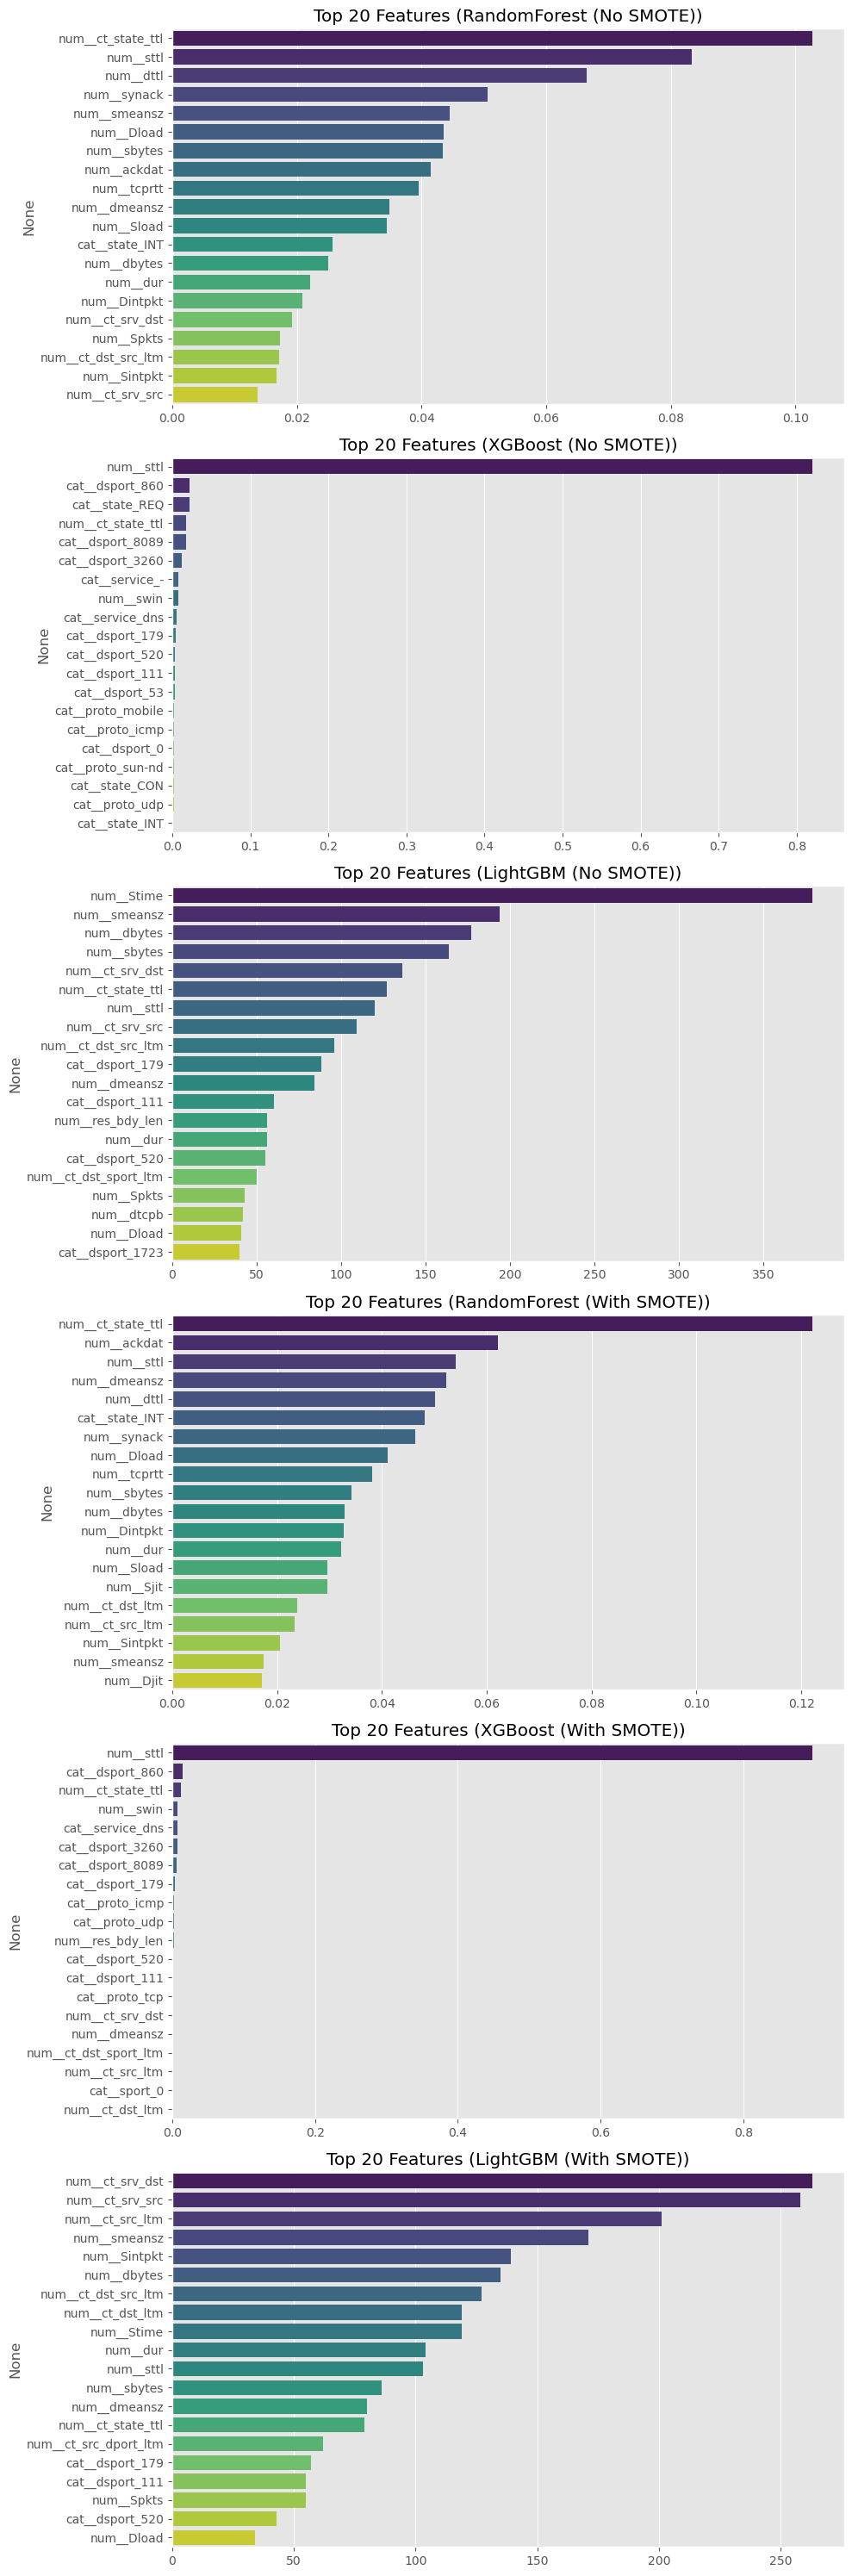


--- Feature Importance Visualization Complete ---


In [11]:
# --- Cell 11: Feature Importance Visualization ---
print("--- Visualizing Feature Importances ---")

if 'feature_importances_without_smote' in locals() and 'feature_importances_with_smote' in locals():
    all_importances = {**feature_importances_without_smote, **feature_importances_with_smote}
    
    if all_importances:
        num_top_features = 20
        n_models = len(all_importances)
        fig, axes = plt.subplots(nrows=n_models, ncols=1, figsize=(10, n_models * 5))
        axes = axes.flatten() if n_models > 1 else [axes]

        for i, (name, importance_data) in enumerate(all_importances.items()):
            importances, feature_names = importance_data
            feature_importance_series = pd.Series(importances, index=feature_names)
            top_features = feature_importance_series.sort_values(ascending=False).head(num_top_features)
            
            sns.barplot(x=top_features.values, y=top_features.index, ax=axes[i], palette='viridis')
            axes[i].set_title(f'Top {num_top_features} Features ({name})')
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo feature importances found.")
else:
    print("\nFeature importance dictionaries not found.")

print("\n--- Feature Importance Visualization Complete ---")

In [12]:
# --- Cell 12: Conclusion and Summary of Winners ---
print("--- Analysis of Model Performance: Category Winners ---")

if 'results_df' in locals() and not results_df.empty:
    best_accuracy_model = results_df['accuracy'].idxmax()
    best_precision_model = results_df['precision_macro'].idxmax()
    best_recall_model = results_df['recall_macro'].idxmax()
    best_f1_model = results_df['f1_macro'].idxmax()
    best_roc_auc_model = results_df['roc_auc'].idxmax()
    
    if 'FN' in results_df.columns:
        lowest_fn_model = results_df['FN'].idxmin()
    else:
        lowest_fn_model = "N/A"
        
    if 'FP' in results_df.columns:
        lowest_fp_model = results_df['FP'].idxmin()
    else:
        lowest_fp_model = "N/A"
        
    fastest_train_model = results_df['train_time_sec'].idxmin()
    
    print("\n\n--- Conclusion: Best Performing Models by Category ---\n")
    print(f"🚀 Fastest Training Time:\t\t{fastest_train_model} ({results_df.loc[fastest_train_model, 'train_time_sec']:.2f} seconds)")
    print("-" * 60)
    print(f"🎯 Highest Accuracy:\t\t\t{best_accuracy_model} ({results_df.loc[best_accuracy_model, 'accuracy']:.4f})")
    print(f"📈 Highest Precision (Macro Avg):\t{best_precision_model} ({results_df.loc[best_precision_model, 'precision_macro']:.4f})")
    print(f"🎣 Highest Recall (Macro Avg):\t\t{best_recall_model} ({results_df.loc[best_recall_model, 'recall_macro']:.4f})")
    print(f"⚖️ Best F1-Score (Balance):\t\t{best_f1_model} ({results_df.loc[best_f1_model, 'f1_macro']:.4f})")
    print(f"📊 Best ROC AUC Score:\t\t\t{best_roc_auc_model} ({results_df.loc[best_roc_auc_model, 'roc_auc']:.4f})")
    print("-" * 60)
    print(f"🚨 Lowest False Positives (FP):\t{lowest_fp_model} (Count: {int(results_df.loc[lowest_fp_model, 'FP']) if 'FP' in results_df.columns else 'N/A'})")
    print(f"🛡️ Lowest False Negatives (FN):\t{lowest_fn_model} (Count: {int(results_df.loc[lowest_fn_model, 'FN']) if 'FN' in results_df.columns else 'N/A'})")
    print("-" * 60)

    results_df['overall_score'] = (results_df['f1_macro'] + results_df['recall_macro']) / 2
    best_overall_model = results_df['overall_score'].idxmax()
    
    print("\n--- Overall Recommendation for NIDS ---\n")
    print(f"🏆 The recommended 'Best Overall' model from this analysis, balancing detection and reliability, is **{best_overall_model}**.")

else:
    print("\nResults DataFrame ('results_df') not found.")

print("\n--- Final Analysis Complete ---")

--- Analysis of Model Performance: Category Winners ---


--- Conclusion: Best Performing Models by Category ---

🚀 Fastest Training Time:		LightGBM (No SMOTE) (16.36 seconds)
------------------------------------------------------------
🎯 Highest Accuracy:			RandomForest (No SMOTE) (0.9937)
📈 Highest Precision (Macro Avg):	RandomForest (No SMOTE) (0.9683)
🎣 Highest Recall (Macro Avg):		XGBoost (No SMOTE) (0.9923)
⚖️ Best F1-Score (Balance):		RandomForest (No SMOTE) (0.9617)
📊 Best ROC AUC Score:			XGBoost (No SMOTE) (0.9993)
------------------------------------------------------------
🚨 Lowest False Positives (FP):	RandomForest (No SMOTE) (Count: 1538)
🛡️ Lowest False Negatives (FN):	LightGBM (No SMOTE) (Count: 26)
------------------------------------------------------------

--- Overall Recommendation for NIDS ---

🏆 The recommended 'Best Overall' model from this analysis, balancing detection and reliability, is **RandomForest (With SMOTE)**.

--- Final Analysis Complete ---
